In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model, model_selection, metrics
import sklearn
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pprint

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Introduction
The united states criminal justice system is large complicated machine that seeks to deliver justice when an offense has been committed. This system has been slowly evolving as our society and culture have changed. Many things that Americans take as natural in our criminal justice systems are quite abnormal among justice systems worldwide. Since the 1990s, America has seen a drastic increase in the incarcerated population. Many Americans believe that this drastic increase in incarceration is a result to increased rates of crime, and that this heightened rate is natural and just. To many it is unclear who is most affected by this drastic change in the application of justice in America. It is also unclear how they are so affected.

There is a lot of existing research exploring incarceration and the criminal justice system. There is a consensus that America incarcerates a larger proportion of its population than any other nation and that people of color are disproportionately affected by this high incarceration rate.

In this project I am interested in understanding more about the criminal justice system and the ways in which the law is being applied differently to people in America. I will explore different ways to quantify claims about mass incarceration and race. I will also be examining things that factor into sentence lengtjh. The factors I will be examining are: offense, age, race, gender, and admission date. There are many things that contribute to sentence length, however the scope of this project is limited to these factors.

# Data
## Source and Credibility
The data that I will be using in this analysis is gathered from primarily two sources. The first is the Bureau of Justice Statistics and the second is a link to a [database](https://catalog.data.gov/dataset/sentenced-inmates-in-correctional-facilities) hosted on [Data.gov](https://www.data.gov) and maintained by the State of Connecticut Department of Corrections. These are highly credible sources because they are primary sources for the data. These organizations are official government agencies which collect, maintain, and report on this data.

## Gathering and Cleaning
All the data which I am using in this report are freely available to the public. Collection and cleaning was relatively simple as the source data was well maintained. The data that I collected from the Bureau of Justice Statistics (BJS) need to be formatted in a way that is easily read by the Python packages I will be using. This data was prepared in .xlsx files as to be easily human readable, however this is not generally easily ingested by programs. I extracted data that I found to be relevant into separate .csv files and kept the original files for reference. The files are
```
incarceration_counts.csv
jail_population.csv
jail_trends.csv
state_jail_data.csv
incarceration_by_race.csv
crime_data.csv.
```

The file that I obtained from the Connecticut Department of Corrections is a very well maintained database. The largest issue I had with this file was mild inconsistency with the way in which certain data was encoded (ex. race was encoded as both `WHITE` and `WHITE\t`). This was the data that I spent the most time working to engineer as it is the data set that I intend to use for different regression-related analyses. The files are
```
individuals.csv
regression_df.csv.

```

## Contents
### Bureau of Justice Statistics Data

In [3]:
incar = pd.read_csv('incarceration_trends.csv')
pop = pd.read_csv('jail_population.csv')
trend = pd.read_csv('jail_trends.csv')
state = pd.read_csv('state_jail_data.csv')
race = pd.read_csv('incarceration_by_race.csv')
crime = pd.read_csv('crime_data.csv')

First we will examine `incarceratio_trends.csv`.
This data set records total jail and prison populations across the United States over time. This is useful in understanding general trends in the U.S. over time.

In [4]:
print(incar[['Year','State prisons','Population']].sample(3))

    Year  State prisons  Population
80  2005        1296693      295.52
13  1938         143152      129.82
58  1983         393015      233.79


Next is `jail_trends.csv` which has more information about the breakdown of the populations of United States prisons and jails. However the data is more infrequent that that of `incarceration_trends.csv`.

In [5]:
cols = ['Pre-trial (unadjusted)','Convicted (unadjusted)']
print(pop[cols].sample(3))

   Pre-trial (unadjusted)  Convicted (unadjusted)
3                331800.0                252600.0
2                228900.0                226600.0
5                494200.0                291200.0


`jail_trends.csv` contains data among the states collected in 2013, comparing different incarceration rate information. This data gives a general breakdown of why different people are being held at a state level

In [6]:
cols = ['Jail growth (1983-2013)','Percent pre-trial (2013)']
print(trend[cols].sample(3))

                      Jail growth (1983-2013)  Percent pre-trial (2013)
Colorado                                 3.04                      0.51
District of Columbia                     1.20                      0.52
Pennsylvania                             3.26                      0.61


`state_jail_data.csv` contains race, gender, and age demographic data of state incarcerated populations. This data will help us understand the demographic breakdown of state incarcerated populations

In [7]:
cols = ['CONFPOP','WHITE','BLACK','ASIAN','JUVMALE','MALE','FEM']
print(state[cols].sample(3))

    CONFPOP  WHITE  BLACK  ASIAN  JUVMALE   MALE   FEM
11    20795   6274  11204     28      265  18204  2307
27     1728   1364    163     15       35   1471   220
40    67418  24910  19619    147      322  58124  8931


`incarceration_by_race.csv` contains race demographic data for incarcerated populations by institution. This will allow us to understand distributions of state incarcerated populations

In [8]:
cols = ['Geography','Total','White','Black','White_rate','Black_rate']
print(race[cols].sample(2))

  Geography  Total  White  Black  White_rate  Black_rate
6  Colorado  40568  28673   7365         701        3651
3   Arizona  67767  36160   8246         775        3184


`crime_data.csv` records crime rates over time in this U.S. This data set will help us understand how crime relates to incarceration.

In [9]:
cols = ['Year','Violent crime','Murder','Rape','Robbery','Assault']
print(crime[cols].sample(3))

    Year  Violent crime  Murder  Rape  Robbery  Assault
32  1992          757.7     9.3  42.8    263.7    441.9
48  2008          458.6     5.4  29.8    145.9    277.5
26  1986          620.1     8.6  38.1    226.0    347.4


### Connecticut Department of Corrections Data

This data set contains individual information for 7.77 million people that have been processed by the justice system and recorded by the Connecticut Department of Corrections.

In [10]:
inmates = pd.read_csv('individuals.csv')

In [11]:
cols = ['LATEST ADMISSION DATE','AGE','RACE','SENTENCE DAYS']
print(inmates[cols].sample(3))

        LATEST ADMISSION DATE  AGE      RACE  SENTENCE DAYS
5212346            07/17/2006   43     BLACK           5114
4342362            09/24/2012   44  HISPANIC          12784
6578807            07/03/2014   46     WHITE           3287


Here is a sample from the altered dataframe that has race, gender, and offence one-hot encoded.

# Analysis and Visualization
## Increased rates
Here we can see the drastic increase of the amount of incarceration in the U.S. Something that is interesting to note is that Jails are defined as places for people who have a sentence less than 1 year, or who are awaiting trial. So we see that at its peak in 2008, there were more people awaiting trial than there were being held in federal prison in 1991.

Here I have incarceration rates plotted against the violent crime rate in the United States. Near the beginning of the crime rate data we might assume some amount of inaccuracy, since the crime rate seems to be less than the incarceration rate, however there is an indisputable spike in crime rates in the 1980s and 1990s. Something to note is that the incarceration rate seems to lag behind about 20 years. Another thing to note is that there has been a strict decrease in violent crime (and in all crime) since the 90s, however we do not see the same decrease in the incarceration rate.

Some would argue that we see this decrease in crime because of the increase of incarceration. I would disagree. Consider the scales of the different curves we see on the chart. Both are in terms of the rate per 100,000, but the crime rate is more that 200 times higher than the incarceration rate in state prisons. Unless 0.5% of people who committed crime in the 90s were committing more than half of all crime, I would argue that there is some other cause for the decrease in crime rates.

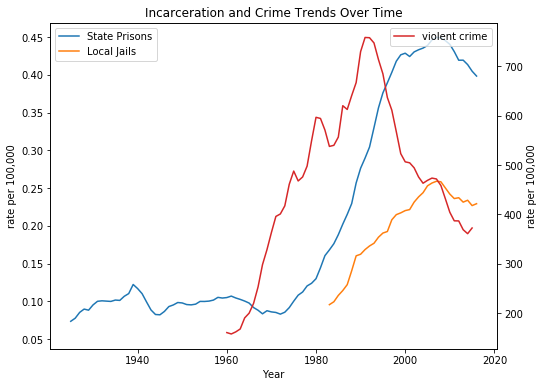

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(
    incar['Year'].values,
    incar['State prisons'].values / (incar.Population*10**4),
    label='State Prisons', color='tab:blue')

ax.plot(
    incar['Year'].values,
    incar['Local jails'].values / (incar.Population*10**4),
    label='Local Jails', color='tab:orange')
ax2 = ax.twinx()
ax2.plot(
    crime.Year, crime['Violent crime'],
    label='violent crime', color='tab:red'
)
ax2.set_ylabel('rate per 100,000')
ax2.legend()
ax.legend()
ax.set_title('Incarceration and Crime Trends Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('rate per 100,000')
plt.show()

## Artifacts of Prison Policy
One might expect sentence lengths to be distributed somewhat smoothly. However there are standard sentence lengths and mandatory minimum sentences that influence the distribution of sentence lenghts, making the distribution not smooth.

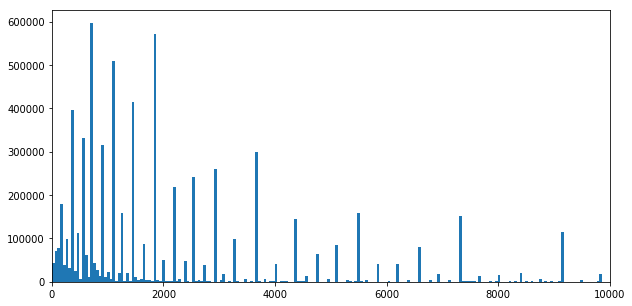

In [13]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.set_xlim(0,10000)
mask = inmates['SENTENCE DAYS'] < 10000
ax.hist(
    inmates['SENTENCE DAYS'][mask].values,
    bins=200
)
plt.show()

In [14]:
inmates.columns

Index(['Unnamed: 0', 'DOWNLOAD DATE', 'IDENTIFIER', 'LATEST ADMISSION DATE',
       'RACE', 'GENDER', 'AGE', 'END SENTENCE DATE', 'OFFENSE', 'FACILITY',
       'DETAINER', 'SENTENCE DAYS',
       'SPECIAL PAROLE END DATE                                                        '],
      dtype='object')

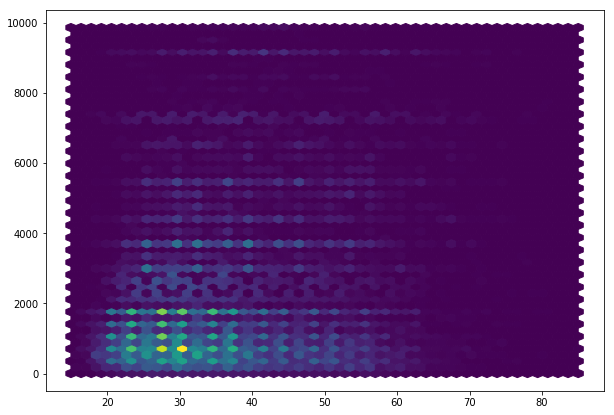

In [15]:
fig, ax = plt.subplots(1, figsize=(10,7))
# ax.set_xlim(0,10000)
mask = inmates['SENTENCE DAYS'] < 10000
ax.hexbin(
    x=inmates.AGE[mask].values,
    y=inmates['SENTENCE DAYS'][mask].values,
    gridsize=50
)
plt.show()

## Racial Disparities
Here we will explore how the criminal justice system affects people of different races.

### Sentence Length
The first chart that we will explore is the distribution of sentence lengths among people of different races. Here we are using the data of more the 7.7 million individuals processed by the criminal justice system.
The medians are compariable on the scale at which sentence length is given. Asians and American Indians have the longest median sentence length, however the standard deviation in their sentence lengths is much less than what is seen in the other racial categories. I would attribute this to there being many more Hispanic, Black, and White people that receive extreme sentence lenghts and this is seen in the max sentence lengths.

In [16]:
races = inmates.groupby(by='RACE')
print(
    'Median sentence lengths:\n {}'.format(races['SENTENCE DAYS'].median())
)
print('\n')
print(
    'Standard deviation of sentence lengths:\n {}'.format(races['SENTENCE DAYS'].std())
)
print('\n')
print(
    'Max sentence lengths:\n {}'.format(races['SENTENCE DAYS'].max())
)

Median sentence lengths:
 RACE
AMER IND    2192
ASIAN       2557
BLACK       1826
HISPANIC    1826
WHITE       1461
Name: SENTENCE DAYS, dtype: int64


Standard deviation of sentence lengths:
 RACE
AMER IND     3208.584729
ASIAN        5122.011265
BLACK       37306.146883
HISPANIC    35763.282330
WHITE       46882.705552
Name: SENTENCE DAYS, dtype: float64


Max sentence lengths:
 RACE
AMER IND     14610
ASIAN        27394
BLACK       368897
HISPANIC    368897
WHITE       368897
Name: SENTENCE DAYS, dtype: int64


This boxplot is where we begin to see disparity in the way people of different races are sentenced. While the first two quartiles of each racial group's sentence lengths are similar, we see that the top two quartiles vary widely.

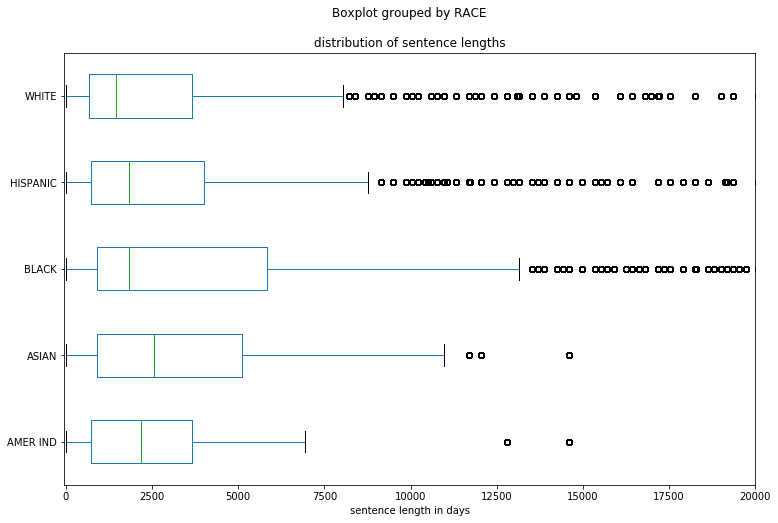

In [17]:
fig, ax = plt.subplots(1, figsize=(12,8))
ax.set_xlim(-50,20000)
bp = inmates.boxplot(
    ['SENTENCE DAYS'], by=['RACE'],
    vert=False, grid=False,
    ax=ax
)
ax.set_title('distribution of sentence lengths')
ax.set_xlabel('sentence length in days')
plt.show()

The following histograms will assist us in understanding these distributions.

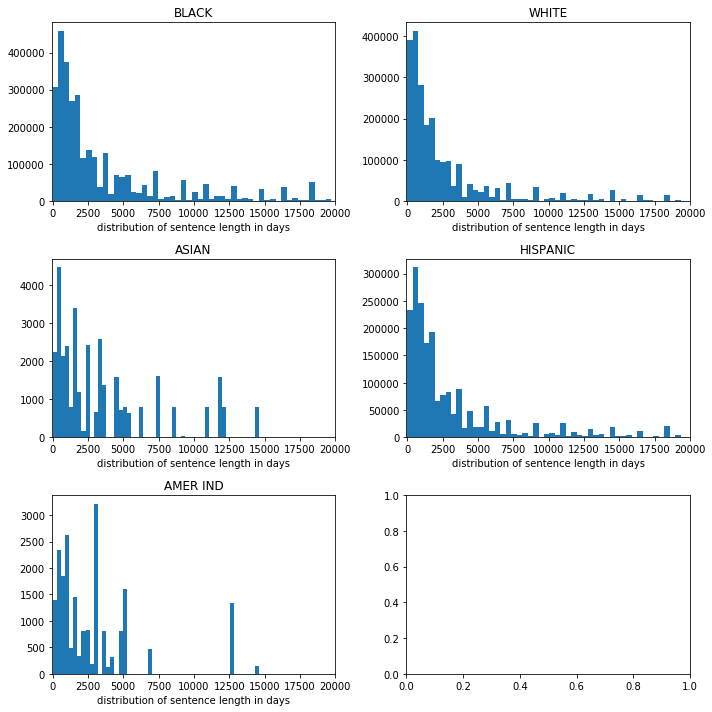

In [18]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
indexer = {
    (0,0):'BLACK',
    (0,1):'WHITE',
    (1,0):'ASIAN',
    (1,1):'HISPANIC',
    (2,0):'AMER IND'
}
for key in indexer.keys():
    ax[key].set_xlim(-50,20000)
    mask = races.get_group(indexer[key])['SENTENCE DAYS'] < 20000
    ax[key].hist(
        races.get_group(indexer[key])['SENTENCE DAYS'][mask],
        bins=50
    )
    ax[key].set_xlabel('distribution of sentence length in days')
    ax[key].set_title(indexer[key])

fig.tight_layout()
plt.show()

While it may appear that these sentences are distributed fairly equivilently, we can examine the kurtosis of the distribution to understand how much of the weight of the distribution is found in the extremities. Groups with high kurtosis have a higher probability of receiving a sentence that is far from the mean.

As we can see, Blacks and Hispanics have the greatest kurtosis. We can expect the very small kurtosis in American Indians and Asians because they had such a small standard deviation.

In [19]:
out = '{} Kurtosis: {}'
kurts = {
    'White':
    stats.kurtosis(races.get_group('WHITE')['SENTENCE DAYS']),
    'Black':
    stats.kurtosis(races.get_group('BLACK')['SENTENCE DAYS']),
    'Hispanic':
    stats.kurtosis(races.get_group('HISPANIC')['SENTENCE DAYS']),
    'American Indian':
    stats.kurtosis(races.get_group('AMER IND')['SENTENCE DAYS']),
    'Asian':
    stats.kurtosis(races.get_group('ASIAN')['SENTENCE DAYS']),
}

for key in kurts.keys():
    print(
        out.format(key, kurts[key])
    )

White Kurtosis: 54.01344161453346
Black Kurtosis: 86.11479232153843
Hispanic Kurtosis: 96.03075354970996
American Indian Kurtosis: 4.0085627062942955
Asian Kurtosis: 7.45297417968173


In [46]:
regr_df = pd.read_csv('small_regression_df.csv')
regr_df.dropna(inplace=True)
sentence = regr_df['SENTENCE DAYS']
regr_df.drop(['SENTENCE DAYS','IDENTIFIER','LATEST ADMISSION DATE','Unnamed: 0'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(regr_df.astype(float), sentence, test_size=.3)
res_gen = sm.OLS(y_train, X_train).fit()
print(res_gen.summary())

                            OLS Regression Results                            
Dep. Variable:          SENTENCE DAYS   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     138.9
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:57:34   Log-Likelihood:            -2.6381e+05
No. Observations:               22824   AIC:                         5.280e+05
Df Residuals:                   22630   BIC:                         5.296e+05
Df Model:                         193                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

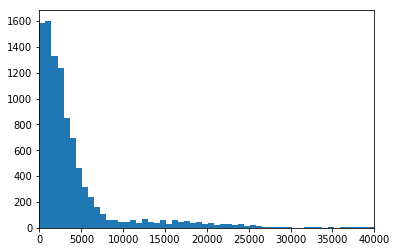

In [50]:
test = res_gen.predict(X_test)
plt.hist(np.abs(test-y_test), bins=500)
plt.xlim(0,40000)
plt.show()

In [44]:
regr_df = pd.read_csv('race_regression_df.csv')
regr_df.dropna(inplace=True)
sentence = regr_df['SENTENCE DAYS']
regr_df.drop(['SENTENCE DAYS','Unnamed: 0'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(regr_df.astype(float), sentence, test_size=.3)
res_gen = sm.OLS(y_train, X_train).fit()
print(res_gen.summary())

                            OLS Regression Results                            
Dep. Variable:          SENTENCE DAYS   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     6140.
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:12:34   Log-Likelihood:            -9.7075e+06
No. Observations:              809642   AIC:                         1.942e+07
Df Residuals:                  809636   BIC:                         1.942e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE          650.3694      3.738    173.983      0.0

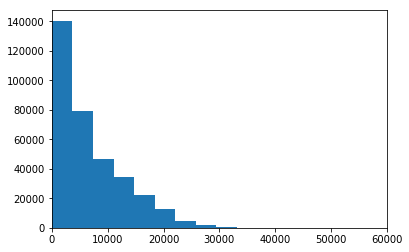

In [45]:
test = res_gen.predict(X_test)
plt.hist(np.abs(test-y_test), bins=100)
plt.xlim(0,60000)
plt.show()